## Airbnb Seattle dataset 2021/02/21
### Create functions to download Airbnb dataset

In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin

DOWNLOAD_ROOT = "http://data.insideairbnb.com/united-states/wa/seattle/2021-02-21/data/"
DATA_PATH = os.path.join("datasets")
FILE_NAMES = ["listings.csv.gz","calendar.csv.gz","reviews.csv.gz"]

def fetch_airbnb_data(download_root=DOWNLOAD_ROOT, data_path=DATA_PATH, file_names=FILE_NAMES):
    """function to download dataset from Inside Airbnb"""
    os.makedirs(data_path, exist_ok=True)
    for filename in file_names:
        gz_path = os.path.join(data_path, filename)
        data_url = download_root + filename
        urllib.request.urlretrieve(data_url, gz_path)

In [472]:
fetch_airbnb_data()

### Functions to load csv data

In [141]:
def load_airbnb_data(filename,data_path=DATA_PATH):
    """load airbnb csv gzip data"""
    csv_path = os.path.join(data_path,filename)
    return pd.read_csv(csv_path,compression="gzip")

In [142]:
listing_full = load_airbnb_data("listings.csv.gz")
calendar = load_airbnb_data("calendar.csv.gz")
# reviews = load_airbnb_data("reviews.csv.gz")

### Listing Dataset

In [105]:
listing_full = listing_full.set_index("id")

In [106]:
## here we grab the attributes we are interested in
listing_attrs = ['latitude','longitude','accommodates','bedrooms','bathrooms_text','minimum_nights','maximum_nights',
                 'availability_90','availability_365','number_of_reviews','number_of_reviews_ltm','review_scores_rating',
                 'calculated_host_listings_count','price','neighbourhood_group_cleansed','room_type','host_is_superhost']

In [107]:
listing = listing_full.loc[:,listing_attrs]
listing.head()

,latitude,longitude,accommodates,bedrooms,bathrooms_text,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,calculated_host_listings_count,price,neighbourhood_group_cleansed,room_type,host_is_superhost
id,,,,,,,,,,,,,,,,,
2318,47.61082,-122.29082,9,4.0,2.5 baths,30,1125,0,107,32,0,100.0,1,$296.00,Central Area,Entire home/apt,f
9419,47.55017,-122.31937,2,1.0,3 shared baths,2,180,53,328,148,0,93.0,7,$55.00,Other neighborhoods,Private room,t
9531,47.55539,-122.38474,4,2.0,1 bath,30,1125,83,327,41,1,100.0,2,$155.00,West Seattle,Entire home/apt,t
9534,47.55624,-122.38598,3,2.0,1 bath,30,1125,27,204,55,7,100.0,2,$125.00,West Seattle,Entire home/apt,t
9596,47.65479,-122.33652,4,1.0,1 bath,4,60,31,31,97,4,91.0,2,$100.00,Other neighborhoods,Entire home/apt,f


In [108]:
listing.shape

(4197, 17)

### Clean Data

In [109]:
## remove text from bathroom column and only keep number of bathrooms
listing["bathrooms_text"].replace(regex={"half":"0.5","Half":"0.5","[a-zA-Z\s-]+":""}, inplace=True)
listing["price"].replace(regex={"\$": "", ",":""}, inplace=True)
listing["bathrooms"] = listing["bathrooms_text"].astype(float)
listing.drop("bathrooms_text",axis=1, inplace=True)
listing["price"] = listing["price"].astype(float)
listing = listing.loc[listing["price"]!=0] ## there is one row with price 0, so we removed it

### Exploratory Data Analysis

In [110]:
listing.head()

,latitude,longitude,accommodates,bedrooms,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,calculated_host_listings_count,price,neighbourhood_group_cleansed,room_type,host_is_superhost,bathrooms
id,,,,,,,,,,,,,,,,,
2318,47.61082,-122.29082,9,4.0,30,1125,0,107,32,0,100.0,1,296.0,Central Area,Entire home/apt,f,2.5
9419,47.55017,-122.31937,2,1.0,2,180,53,328,148,0,93.0,7,55.0,Other neighborhoods,Private room,t,3.0
9531,47.55539,-122.38474,4,2.0,30,1125,83,327,41,1,100.0,2,155.0,West Seattle,Entire home/apt,t,1.0
9534,47.55624,-122.38598,3,2.0,30,1125,27,204,55,7,100.0,2,125.0,West Seattle,Entire home/apt,t,1.0
9596,47.65479,-122.33652,4,1.0,4,60,31,31,97,4,91.0,2,100.0,Other neighborhoods,Entire home/apt,f,1.0


In [111]:
listing.describe()

,latitude,longitude,accommodates,bedrooms,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,calculated_host_listings_count,price,bathrooms
count,4196.000000,4196.000000,4196.000000,3619.000000,4196.000000,4196.000000,4196.000000,4196.000000,4196.000000,4196.000000,3419.000000,4196.000000,4196.000000,4192.000000
mean,47.624850,-122.334591,3.660629,1.568942,16.522402,595.730934,48.403718,179.824357,62.193518,8.222355,95.436385,18.291706,127.406101,1.294967
std,0.046865,0.033060,2.254527,0.906574,19.833424,524.647397,33.877343,130.717911,91.836522,13.953093,7.595287,38.370799,111.624494,0.716913
min,47.496210,-122.418760,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,15.000000,0.000000
25%,47.604558,-122.356342,2.000000,1.000000,2.000000,56.750000,12.750000,61.000000,2.000000,0.000000,95.000000,1.000000,75.000000,1.000000
50%,47.620935,-122.334570,3.000000,1.000000,4.500000,365.000000,53.000000,171.000000,23.000000,2.000000,98.000000,2.000000,100.000000,1.000000
75%,47.660113,-122.310958,4.000000,2.000000,30.000000,1125.000000,83.000000,319.250000,85.250000,11.000000,99.000000,7.000000,145.000000,1.000000
max,47.733530,-122.245540,16.000000,7.000000,365.000000,10000.000000,90.000000,365.000000,959.000000,129.000000,100.000000,146.000000,3212.000000,16.000000


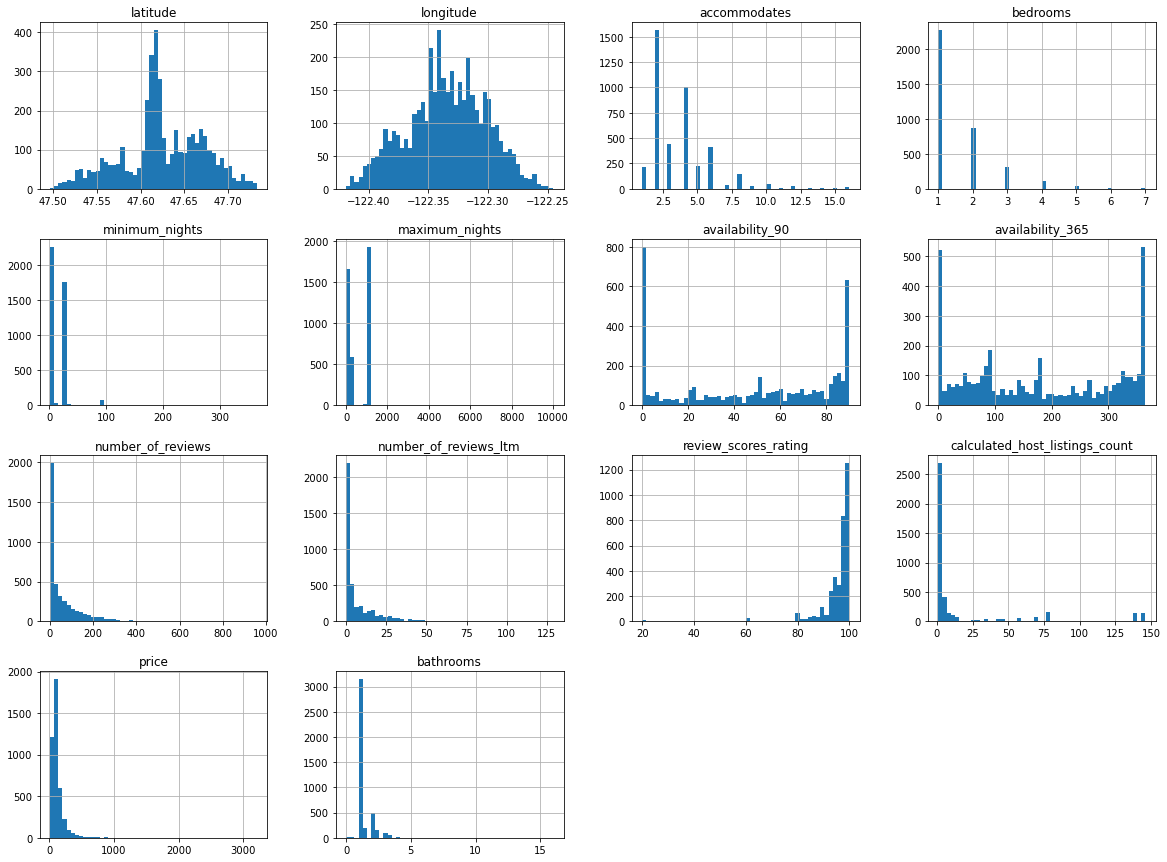

In [112]:
## plot histograms of numerical features
listing.hist(bins=50, figsize=(20,15))
plt.show()

### Plot Seattle Map

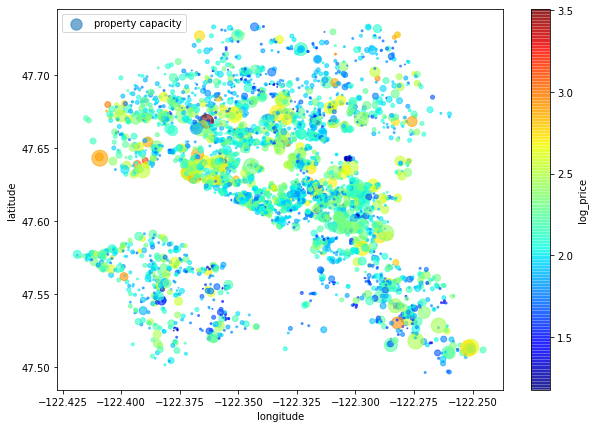

In [114]:
## We can see from histogram of price feature that it is heavy tailed
## Thus, we created another feature by taking log10 of price so price difference is clear with visualization.
listing_map = listing.copy()
listing_map["log_price"] = np.log10(listing_map["price"])
fig, ax = plt.subplots()
listing_map.plot(ax=ax,kind="scatter",x="longitude",y="latitude",alpha=0.6,s=listing["accommodates"]**2,label="property capacity",
            figsize=(10,7), c="log_price",cmap=plt.get_cmap("jet"),colorbar=True)
plt.savefig("Seattle_map_price.png")
plt.show()

### Calendar Dataset

In [143]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1355094,2021-02-21,f,$27.00,$26.00,30.0,1125.0
1,1356339,2021-02-21,f,$119.00,$119.00,2.0,1125.0
2,1356339,2021-02-22,f,$119.00,$119.00,2.0,1125.0
3,1356339,2021-02-23,f,$119.00,$119.00,2.0,1125.0
4,1356339,2021-02-24,f,$119.00,$119.00,2.0,1125.0


In [148]:
calendar["listing_id"].nunique()

4196

### Clean Calendar Dataset

In [144]:
calendar['date'] = pd.to_datetime(calendar['date']) ## convert date from string to date format
calendar["price"].replace(regex={"[\$,]":""},inplace=True)
calendar["price"] = calendar["price"].astype(float)
calendar["adjusted_price"].replace(regex={"[\$,]":""},inplace=True)
calendar["adjusted_price"] = calendar["price"].astype(float)

### Price Trend throughout the year

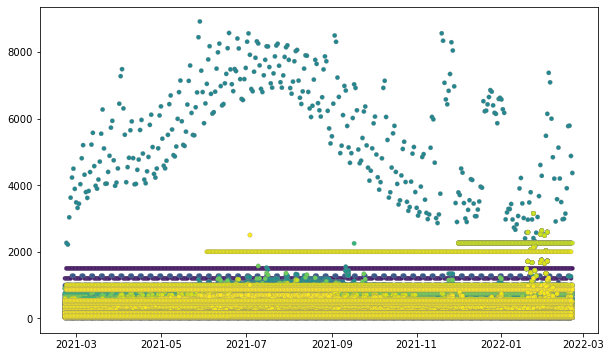

In [145]:
fig = plt.figure(figsize=(10,6))
plt.scatter(data=calendar,x='date',y='price',c="listing_id",
              s=20,linewidths=0.2,edgecolors='gray',label=None)

plt.savefig("seasonality.png")
plt.show()

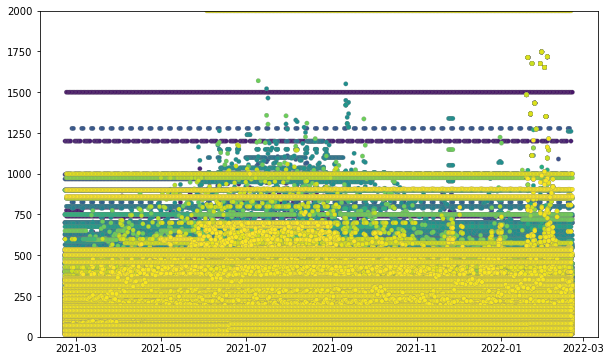

In [146]:
fig = plt.figure(figsize=(10,6))
plt.scatter(data=calendar,x='date',y='price',c="listing_id",
              s=20,linewidths=0.2,edgecolors='gray',label=None)
plt.ylim(0,2000)
plt.savefig("seasonality_zoom.png")
plt.show()

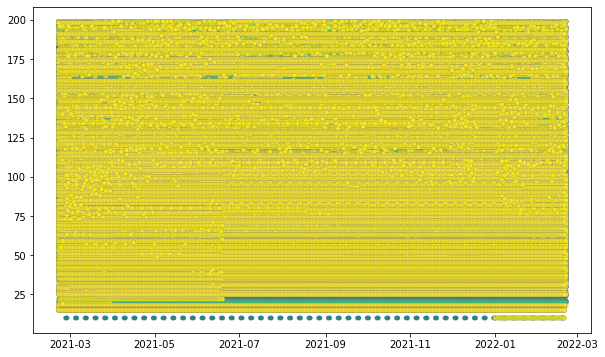

In [152]:
calendar = calendar[calendar["price"] < 200]
fig = plt.figure(figsize=(10,6))
plt.scatter(data=calendar,x='date',y='price',c="listing_id",
              s=20,linewidths=0.2,edgecolors='gray',label=None)

### Building models to predict Price

In [61]:
listing.head()

,latitude,longitude,accommodates,bedrooms,minimum_nights,maximum_nights,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,calculated_host_listings_count,price,neighbourhood_group_cleansed,room_type,host_is_superhost,bathrooms
id,,,,,,,,,,,,,,,,,
2318,47.61082,-122.29082,9,4.0,30,1125,0,107,32,0,100.0,1,296.0,Central Area,Entire home/apt,f,2.5
9419,47.55017,-122.31937,2,1.0,2,180,53,328,148,0,93.0,7,55.0,Other neighborhoods,Private room,t,3.0
9531,47.55539,-122.38474,4,2.0,30,1125,83,327,41,1,100.0,2,155.0,West Seattle,Entire home/apt,t,1.0
9534,47.55624,-122.38598,3,2.0,30,1125,27,204,55,7,100.0,2,125.0,West Seattle,Entire home/apt,t,1.0
9596,47.65479,-122.33652,4,1.0,4,60,31,31,97,4,91.0,2,100.0,Other neighborhoods,Entire home/apt,f,1.0


In [62]:
## grab features we are interested in
listing = listing[['latitude','longitude','accommodates','bedrooms','bathrooms','minimum_nights','maximum_nights',
                 'availability_90','availability_365','number_of_reviews','number_of_reviews_ltm','review_scores_rating',
                 'calculated_host_listings_count','price','neighbourhood_group_cleansed','room_type','host_is_superhost']]

### Split Training and test

<AxesSubplot:>

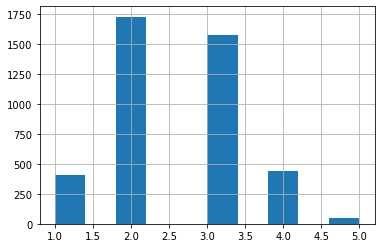

In [63]:
## create interval for price so we can use StratifiedSplit
listing["price_cat"] = pd.cut(listing["price"],
                             bins=[0., 50., 100., 200., 500., np.inf],
                             labels=[1,2,3,4,5])
listing["price_cat"].hist()

In [64]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(listing, listing["price_cat"]):
    strat_train_set = listing.iloc[train_index]
    strat_test_set = listing.iloc[test_index]
strat_test_set["price_cat"].value_counts()/len(strat_test_set)

2    0.410714
3    0.375000
4    0.105952
1    0.096429
5    0.011905
Name: price_cat, dtype: float64

In [65]:
strat_train_set.drop("price_cat", axis=1, inplace=True)
strat_test_set.drop("price_cat", axis=1, inplace=True)

C:\Users\j8654\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Relationship of price with other features

In [66]:
## from correlation values, we can guess size of property is positively correlated with price
corr_matrix = listing.corr()
corr_matrix["price"].sort_values(ascending=False)

price                             1.000000
bedrooms                          0.507738
accommodates                      0.505371
bathrooms                         0.362260
availability_365                  0.083644
maximum_nights                    0.079040
review_scores_rating              0.071893
availability_90                   0.031657
latitude                          0.030996
minimum_nights                    0.030387
calculated_host_listings_count    0.026386
longitude                        -0.077897
number_of_reviews                -0.117092
number_of_reviews_ltm            -0.118495
Name: price, dtype: float64

array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='bedrooms', ylabel='price'>,
        <AxesSubplot:xlabel='accommodates', ylabel='price'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='price'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='bedrooms'>,
        <AxesSubplot:xlabel='bedrooms', ylabel='bedrooms'>,
        <AxesSubplot:xlabel='accommodates', ylabel='bedrooms'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='bedrooms'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='bedrooms'>],
       [<AxesSubplot:xlabel='price', ylabel='accommodates'>,
        <AxesSubplot:xlabel='bedrooms', ylabel='accommodates'>,
        <AxesSubplot:xlabel='accommodates', ylabel='accommodates'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='accommodates'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='accommodates'>],
       [<AxesSubplot:xlabel='price', ylabel='bathrooms'>,
 

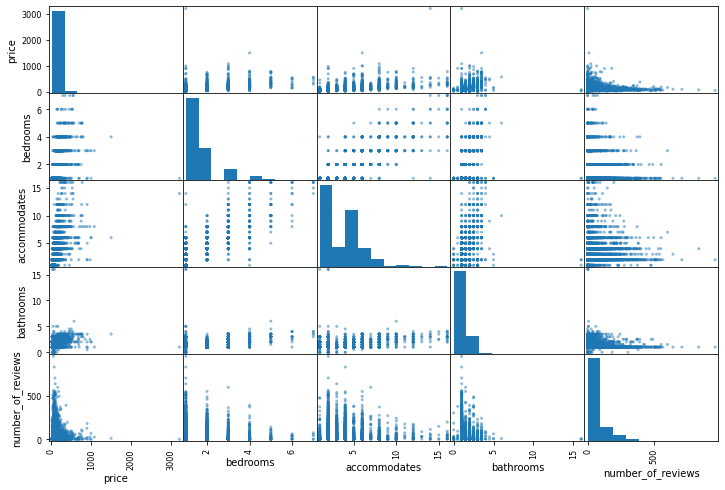

In [67]:
attributes = ["price","bedrooms","accommodates","bathrooms","number_of_reviews"]
scatter_matrix(listing[attributes],figsize=(12,8))

In [68]:
listing = strat_train_set.drop("price",axis=1)
listing_labels = strat_train_set["price"].copy()

### Prepare data for modeling

In [77]:
## use class as feature transformer, which will be useful in hyperparameter tunning later. 
bathrooms_ix, bedrooms_ix, reviews_num_ix, reviews_score_ix = 3, 4, 9, 11

class CombineAttrAdder(BaseEstimator, TransformerMixin):
    """combine reviews, bedroom and bathroom attributes and add to dataset"""
    def __init__(self, add_bedrooms_bathrooms = True):
        self.add_bedrooms_bathrooms = add_bedrooms_bathrooms
    def fit(self, y=None):
        return self
    def transform(self, X):
        mean_reviews = np.zeros(len(X))
        no_reviews = X[:,reviews_num_ix] == 0
        mean_reviews[no_reviews] = np.nan
        mean_reviews[~no_reviews] = X[~no_reviews,reviews_score_ix] / X[~no_reviews,reviews_num_ix]
        if self.add_bedrooms_bathrooms:
            bedrooms_bathrooms = X[:,bedrooms_ix] + X[:,bathrooms_ix]
            return np.c_[X, mean_reviews, bedrooms_bathrooms]
        else:
            return np.c_[X, mean_reviews]

attr_adder = CombineAttrAdder(add_bedrooms_bathrooms=False)
listing_extra_attrs = attr_adder.transform(listing.values)

In [78]:
## using pipeline to fill NA values and add new features
listing_num = listing.drop(["host_is_superhost","neighbourhood_group_cleansed","room_type"],axis=1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attrs_adder', CombineAttrAdder()),
    ('imputer2', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])
listing_num_tr = num_pipeline.fit_transform(listing_num)

In [79]:
## using ColumnTransformer to put together numeric and categorical transformer
num_attribs = list(listing_num)
cat_attribs = ["neighbourhood_group_cleansed","room_type","host_is_superhost"]

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy="most_frequent")),
    ('one_hot', OneHotEncoder())])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

listing_prepared = full_pipeline.fit_transform(listing)

### Cross-Validation: Linear Regression and RandomForest

In [75]:
lin_reg = LinearRegression(normalize=True)
scores = cross_val_score(lin_reg, listing_num_tr, listing_labels, scoring="neg_mean_squared_error", cv=10)
np.sqrt(-scores).mean()

94.24378818401536

In [80]:
rf_reg = RandomForestRegressor()
scores = cross_val_score(rf_reg, listing_prepared, listing_labels, scoring="neg_mean_squared_error", cv=10)
np.sqrt(-scores).mean()

87.66221094889924

In [82]:
### RandomForest looks better, so we fine-tune hyperparameters
param_dis = {
    'n_estimators': randint(low=1,high=300),
    'max_features':randint(low=1,high=30),
    'max_depth': randint(low=2, high=50),
    'min_samples_leaf': randint(low=1, high=50)
    }
forest_reg = RandomForestRegressor()
rnt_search = RandomizedSearchCV(forest_reg, param_distributions= param_dis, n_iter=10, cv=5,
                          scoring="neg_mean_squared_error")
rnt_search.fit(listing_prepared, listing_labels)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000257E63B5910>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000257E0D5DDF0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000257E0D5D670>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000257E0D5DD30>},
                   scoring='neg_mean_squared_error')

In [83]:
rnt_search.best_params_

{'max_depth': 44,
 'max_features': 18,
 'min_samples_leaf': 18,
 'n_estimators': 141}

In [84]:
cvres = rnt_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score), params)

93.85809800416361 {'max_depth': 24, 'max_features': 29, 'min_samples_leaf': 29, 'n_estimators': 149}
94.35093640748805 {'max_depth': 5, 'max_features': 27, 'min_samples_leaf': 28, 'n_estimators': 68}
93.74375848780197 {'max_depth': 17, 'max_features': 15, 'min_samples_leaf': 32, 'n_estimators': 171}
93.5301118853705 {'max_depth': 37, 'max_features': 18, 'min_samples_leaf': 27, 'n_estimators': 59}
94.41403066645637 {'max_depth': 19, 'max_features': 20, 'min_samples_leaf': 40, 'n_estimators': 67}
105.39986463649863 {'max_depth': 39, 'max_features': 1, 'min_samples_leaf': 21, 'n_estimators': 98}
92.44337247653607 {'max_depth': 44, 'max_features': 18, 'min_samples_leaf': 18, 'n_estimators': 141}
108.05313890388184 {'max_depth': 47, 'max_features': 1, 'min_samples_leaf': 41, 'n_estimators': 119}
94.84346273433374 {'max_depth': 24, 'max_features': 29, 'min_samples_leaf': 44, 'n_estimators': 209}
96.42347033308076 {'max_depth': 24, 'max_features': 3, 'min_samples_leaf': 25, 'n_estimators': 27

### Evaluate both models with test set

In [99]:
final_model = rnt_search.best_estimator_

X_test = strat_test_set.drop("price",axis=1)
y_test = strat_test_set["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

62.035147500453405

In [100]:
## We only fit numeric features into linear regression
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(listing_num_tr, listing_labels)
listing_preds = lin_reg.predict(listing_num_tr)
# lin_mse = mean_squared_error(listing_labels, listing_preds)
# lin_rmse = np.sqrt(lin_mse)
# lin_rmse

In [101]:
### performace of both model are closer than expected
X_test_num = X_test.drop(["host_is_superhost","neighbourhood_group_cleansed","room_type"],axis=1)
X_test_num = num_pipeline.transform(X_test_num)
final_predictions = lin_reg.predict(X_test_num)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

65.98624897287372

### Feature Importance

In [96]:
feature_importances = rnt_search.best_estimator_.feature_importances_
feature_importances

array([2.74328225e-02, 2.91481127e-02, 1.38889243e-01, 1.06119696e-01,
       6.96429851e-02, 8.43598143e-03, 8.52905653e-03, 6.89636767e-02,
       3.44472371e-02, 1.51375458e-02, 3.69657512e-02, 9.11941879e-03,
       1.81976398e-02, 9.02734890e-03, 3.60902073e-01, 1.81812800e-04,
       2.68708825e-06, 1.77891158e-04, 6.68774035e-03, 1.43570128e-04,
       1.24329387e-04, 3.03111582e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.52390454e-04, 1.14072076e-03,
       0.00000000e+00, 0.00000000e+00, 1.16001018e-04, 1.22620118e-05,
       2.76754455e-02, 0.00000000e+00, 1.58360924e-02, 1.42284547e-03,
       1.13411695e-03, 9.02390760e-04])

In [97]:
extra_attr = ["mean_review_score","bedrooms_bathrooms"]
cat_encoder = full_pipeline.named_transformers_["cat"]["one_hot"]
one_hot_attrs = []
for att in cat_encoder.categories_: one_hot_attrs.extend(list(att))
attrs = num_attribs + extra_attr + one_hot_attrs
sorted(zip(feature_importances, attrs), reverse=True)

[(0.3609020727844429, 'bedrooms_bathrooms'),
 (0.13888924279720155, 'accommodates'),
 (0.10611969584610122, 'bedrooms'),
 (0.06964298509061613, 'bathrooms'),
 (0.0689636766919872, 'availability_90'),
 (0.03696575116957759, 'number_of_reviews_ltm'),
 (0.03444723710745096, 'availability_365'),
 (0.02914811269680713, 'longitude'),
 (0.02767544552552064, 'Entire home/apt'),
 (0.027432822528607858, 'latitude'),
 (0.01819763975599156, 'calculated_host_listings_count'),
 (0.01583609237199011, 'Private room'),
 (0.015137545839222033, 'number_of_reviews'),
 (0.009119418786024739, 'review_scores_rating'),
 (0.00902734889502805, 'mean_review_score'),
 (0.008529056525840763, 'maximum_nights'),
 (0.0084359814321167, 'minimum_nights'),
 (0.0066877403472971435, 'Cascade'),
 (0.0030311158242309157, 'Downtown'),
 (0.0014228454676136764, 'Shared room'),
 (0.001140720759065798, 'Queen Anne'),
 (0.0011341169510227364, 'f'),
 (0.00090239076030322, 't'),
 (0.00045239045421772663, 'Other neighborhoods'),
 (0

In [98]:
## coefficients of linear regression are similar to feature importances
sorted(zip(lin_reg.coef_, list(listing_num)+["mean_review_score","bedrooms_bathrooms"]), reverse=True)

[(37.613291180229396, 'accommodates'),
 (12.371073684606845, 'bedrooms'),
 (11.019893794607418, 'bedrooms_bathrooms'),
 (8.11142684985965, 'review_scores_rating'),
 (6.413946378232176, 'availability_90'),
 (6.334974524742088, 'bathrooms'),
 (5.73526453064844, 'calculated_host_listings_count'),
 (4.333631756544576, 'latitude'),
 (3.974728307297653, 'availability_365'),
 (3.8613294953205104, 'maximum_nights'),
 (3.5130362550486165, 'minimum_nights'),
 (-1.7572169004492615, 'mean_review_score'),
 (-3.5006489522750877, 'number_of_reviews'),
 (-9.112299834641307, 'longitude'),
 (-9.39038643797767, 'number_of_reviews_ltm')]

In [ ]:
### top 6 feature importances of both model look similar
### they include property size, reviews, and availability

#### Note: This is my first data science project. I took this chance to practice my data science skill. A portion of codes were borrowed from chapter 2 of Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron.